## Ravasz Algorithm

In [16]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

#### Similarity Calculation

In [17]:
def ravaszSimilarityCalc(G:nx.Graph,u,v):
    u_neigh = set(G.neighbors(u))
    v_neigh = set(G.neighbors(v))
    comm_neigh = len(u_neigh.intersection(v_neigh))
    direct = 1 if G.has_edge(u, v) else 0
    min_deg = min(G.degree[u],G.degree[v])
    if (min_deg + 1) == 0:
        return 0.0
    return (comm_neigh + direct )/ (min_deg + 1)

#### Similarity matrix creation

In [18]:
def similarityMatrix(G:nx.Graph):
    nodes = list(G.nodes())
    n = len(nodes)
    sim_matrix = pd.DataFrame(0.0,index=nodes, columns=nodes, dtype=float)

    sim_matrix.loc[nodes[0],nodes[0]] = 0
    for i in range(n):
        for j in range(i + 1, n):
            u = nodes[i]
            v = nodes[j]
            sim = ravaszSimilarityCalc(G, u, v)
            sim_matrix.loc[u, v] = sim
            sim_matrix.loc[v, u] = sim 
    return sim_matrix


#### Aglomeration

In [ ]:
def getMaxSim(matrix:pd.DataFrame):
    df_copy = matrix.copy()
    np.fill_diagonal(df_copy.values, -np.inf) 
    max_val = df_copy.max().max()
    
    if max_val == -np.inf or max_val <= 0: 
        return {"row": None, "col": None, "value": -np.inf}
        
    col_max_val = df_copy.max().idxmax()
    row_max_val = df_copy[col_max_val].idxmax()
    return {
        "row":row_max_val,
        "col":col_max_val,
        "value":float(max_val)
    }

def combineMax(sim:pd.DataFrame):
    maxi = getMaxSim(sim)
    if maxi["row"] is None:
        return sim
    newName = f"{maxi['row']}{maxi['col']}" 
    if sim.shape[0] == 2:
        final_matrix = pd.DataFrame(
            [0.0], 
            index=[newName], 
            columns=[newName],
            dtype=float
        )
        return final_matrix
    
    newSims = (sim[maxi["row"]]+sim[maxi["col"]])/2
    df_updated = sim.drop(index=[maxi["row"], maxi["col"]], columns=[maxi["row"], maxi["col"]])

    df_updated.loc[newName] = newSims.drop([maxi["row"], maxi["col"]])
    df_updated[newName] = newSims.drop([maxi["row"], maxi["col"]])
    df_updated.loc[newName,newName] = 0.0 
    return df_updated

def aglo(G:nx.Graph):
    sim = similarityMatrix(G)
    nodes = G.nodes()
    n = len(nodes)
    
    print("--- Initial Matrix ---")
    print(sim.to_markdown(floatfmt=".3f"))
    
    for i in range(n-1):
        print(f"\n--- Step {i+1} (Merging {n-i} clusters) ---")
        if sim.shape[0] <= 1:
            print("Clustering complete.")
            break
            
        sim = combineMax(sim)
        print(sim.to_markdown(floatfmt=".3f")) 

    print("\n--- Final Cluster ---")
    print(sim.index[0])        

#### Running program

--- Similarity Matrix ---
|    |     A |     B |     C |     D |     E |     F |     G |     H |     I |     J |     K |
|:---|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| A  | 0.000 | 0.667 | 0.667 | 0.333 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
| B  | 0.667 | 0.000 | 0.667 | 0.333 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
| C  | 0.667 | 0.667 | 0.000 | 0.250 | 0.250 | 0.000 | 0.000 | 0.000 | 0.250 | 0.000 | 0.000 |
| D  | 0.333 | 0.333 | 0.250 | 0.000 | 0.250 | 0.333 | 0.250 | 0.250 | 0.250 | 0.250 | 0.333 |
| E  | 0.000 | 0.000 | 0.250 | 0.250 | 0.000 | 0.667 | 0.500 | 0.250 | 0.250 | 0.000 | 0.000 |
| F  | 0.000 | 0.000 | 0.000 | 0.333 | 0.667 | 0.000 | 0.667 | 0.333 | 0.000 | 0.000 | 0.000 |
| G  | 0.000 | 0.000 | 0.000 | 0.250 | 0.500 | 0.667 | 0.000 | 0.250 | 0.250 | 0.250 | 0.000 |
| H  | 0.000 | 0.000 | 0.000 | 0.250 | 0.250 | 0.333 | 0.250 | 0.000 | 0.500 | 0.500 | 0.667 |
| I  | 0.000 | 0.000 | 0

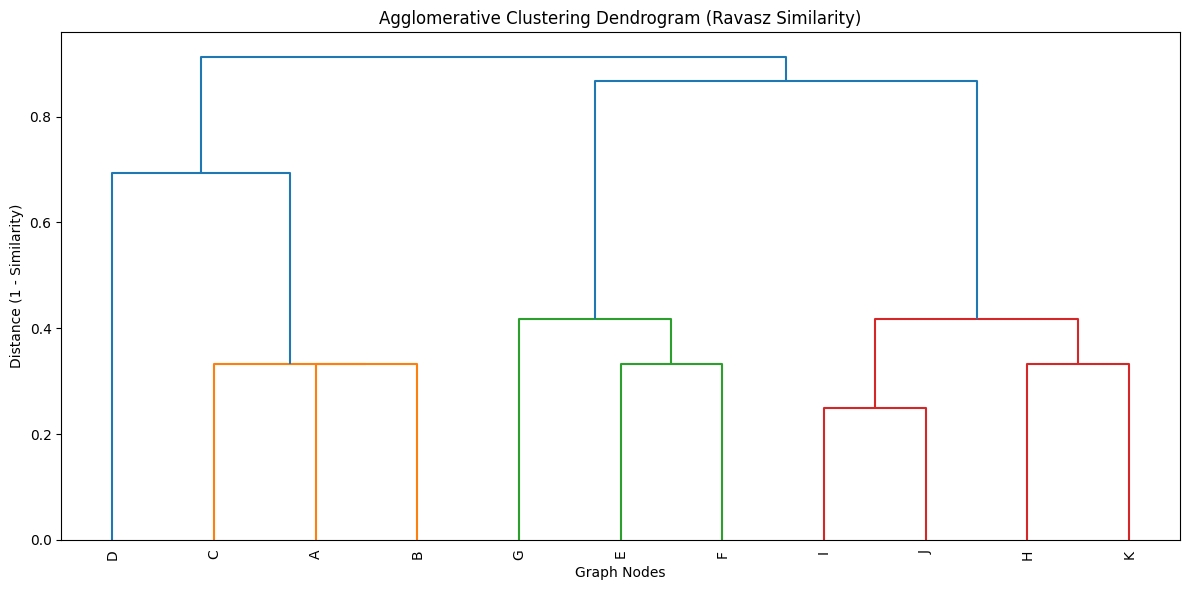

In [25]:
G = nx.Graph()

G.add_nodes_from("ABCDEFGHIJK")

G.add_edges_from([
    ('A', 'B'), ('A', 'C'), ('B', 'C'), ('C', 'D'), ('D', 'E'), ('D', 'I'),
    ('E', 'F'), ('E', 'G'), ('F', 'G'), ('G', 'H'), ('H', 'I'), ('H', 'J'),
    ('I', 'K'), ('J', 'K'), ('I', 'J')
])

print("--- Similarity Matrix ---")
sim_df = similarityMatrix(G)
print(sim_df.to_markdown(floatfmt=".3f"))

dist_df = 1 - sim_df
dist_df_copy = dist_df.copy(True)
np.fill_diagonal(dist_df_copy.values, 0) 
condensed_dist = squareform(dist_df_copy)
print("\n--- Generating Linkage Matrix (Z) ---")
Z = hierarchy.linkage(condensed_dist, method='average')

# 6. Plot the dendrogram
print("--- Plotting Dendrogram ---")
plt.figure(figsize=(12, 6))
plt.title('Agglomerative Clustering Dendrogram (Ravasz Similarity)')
plt.xlabel('Graph Nodes')
plt.ylabel('Distance (1 - Similarity)')

dn = hierarchy.dendrogram(
    Z,
    labels=sim_df.index.to_list(), # Use your node names
    leaf_rotation=90,
    leaf_font_size=10
)

plt.tight_layout()
plt.show()